In [1]:
!pip install tensorflow pandas matplotlib scikit-learn

In [2]:
import os   # for navigating thorugh different file paths
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df.iloc[3]['comment_text']

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [6]:
df[df.columns[2:]].iloc[3]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 3, dtype: int64

# Preprocess Comments

In [7]:
from tensorflow.keras.layers import TextVectorization     # text vectorization layer to be used for tokenisation
# it's a preprocessing layer which maps text features to integer sequences

In [8]:
# split comments and features

X = df['comment_text']  # comments
y = df[df.columns[2:]].values  # labels

In [9]:
MAX_FEATURES = 200000  # No. of words in the vocabulary

In [10]:
# initialise text vectorization layer
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [11]:
# teach vectorizer the vocabulary
vectorizer.adapt(X.values)

In [12]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 np.str_('the'),
 np.str_('to'),
 np.str_('of'),
 np.str_('and'),
 np.str_('a'),
 np.str_('you'),
 np.str_('i'),
 np.str_('is'),
 np.str_('that'),
 np.str_('in'),
 np.str_('it'),
 np.str_('for'),
 np.str_('this'),
 np.str_('not'),
 np.str_('on'),
 np.str_('be'),
 np.str_('as'),
 np.str_('have'),
 np.str_('are'),
 np.str_('your'),
 np.str_('with'),
 np.str_('if'),
 np.str_('article'),
 np.str_('was'),
 np.str_('or'),
 np.str_('but'),
 np.str_('page'),
 np.str_('my'),
 np.str_('an'),
 np.str_('from'),
 np.str_('by'),
 np.str_('do'),
 np.str_('at'),
 np.str_('about'),
 np.str_('me'),
 np.str_('so'),
 np.str_('wikipedia'),
 np.str_('can'),
 np.str_('what'),
 np.str_('there'),
 np.str_('all'),
 np.str_('has'),
 np.str_('will'),
 np.str_('talk'),
 np.str_('please'),
 np.str_('would'),
 np.str_('its'),
 np.str_('no'),
 np.str_('one'),
 np.str_('just'),
 np.str_('like'),
 np.str_('they'),
 np.str_('he'),
 np.str_('dont'),
 np.str_('which'),
 np.str_('any'),
 np.str_('been'),
 np

In [13]:
vectorized_text = vectorizer(X.values)
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [14]:
# creating tensorflow data pipeline

#MCSBP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file --> operations in tensorflow data pipeline
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [15]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [16]:
len(dataset)   # no. of batches

9974

In [17]:
train = dataset.take(int(len(dataset)*.7))  # train 70% of data
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))  # validation of 20% of data
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))  # 10% of data for testing

# Create Sequential Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [19]:
# creating neural network 

model = Sequential()   #instantiate sequential API

# create embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))

# create bidirectional LSTM layer
model.add(Bidirectional(LSTM(32, activation='tanh')))  # used 'tanh' activation function because the gpu acceleration that is required for an LSTM layer needs to be 10h

# Feature extractor, Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# Final layer
model.add(Dense(6, activation='sigmoid'))

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
model.build(input_shape=(None, None))

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,491,686 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# train the neural network
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2605s 373ms/step - accuracy: 0.9638 - loss: 0.0829 - val_accuracy: 0.9946 - val_loss: 0.0454
Epoch 2/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2750s 394ms/step - accuracy: 0.9800 - loss: 0.0454 - val_accuracy: 0.9946 - val_loss: 0.0397
Epoch 3/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2540s 364ms/step - accuracy: 0.9696 - loss: 0.0404 - val_accuracy: 0.9940 - val_loss: 0.0364
Epoch 4/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2669s 382ms/step - accuracy: 0.9819 - loss: 0.0372 - val_accuracy: 0.9945 - val_loss: 0.0314
Epoch 5/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2643s 379ms/step - accuracy: 0.9935 - loss: 0.0325 - val_accuracy: 0.9947 - val_loss: 0.0284


In [24]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

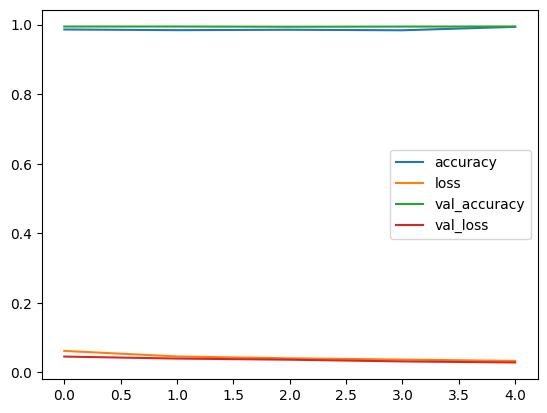

In [25]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Make Predictions

In [26]:
input_text = vectorizer("You are an idiot!!..get lost or I'll hit you")

In [27]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([ 7, 20, 30, ...,  0,  0,  0])>

In [28]:
model.predict(np.expand_dims(input_text, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


array([[8.4142941e-01, 9.5946854e-04, 1.5159310e-01, 7.9496246e-04,
        2.6209059e-01, 5.5799438e-03]], dtype=float32)

In [29]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [30]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [31]:
(res > 0.5).astype(int)

array([[1, 0, 0, 0, 0, 0]])

In [32]:
batch = test.as_numpy_iterator().next()

In [33]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [34]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [35]:
res.shape

(1, 6)

# Evaluate the Model

In [36]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [37]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [38]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

2025-02-19 00:46:53.772993: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [39]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8485862016677856, Recall:0.8156049251556396, Accuracy:0.4934804439544678


In [40]:
!pip install gradio jinja2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 4.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 4.4 MB/s eta 0:00:0000:0100:01


In [41]:
import tensorflow as tf
import gradio as gr

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
model.save('toxicity.h5')

In [43]:
model = tf.keras.models.load_model('toxicity.h5')

In [47]:
input_str = vectorizer('I really hate you!')

In [48]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [49]:
res

array([[4.2084917e-01, 9.3809664e-05, 2.3514960e-02, 3.5636926e-03,
        7.7526249e-02, 9.8059932e-03]], dtype=float32)

In [50]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [52]:
interface = gr.Interface(
    fn=score_comment, 
    inputs=gr.Textbox(lines=2, placeholder="Comment to score"),
    outputs=gr.Text()
)

In [53]:
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://1714483688f1c03dc6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
